In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, mean_squared_error, r2_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, Dense, Dropout

In [14]:
# 1. Load and preprocess dataset
df = pd.read_csv('training_dataset_no_stopwords.csv')

In [15]:
# Assume columns: 'text', 'label'
texts = df['Sentiment'].astype(str).tolist()
labels = df['Label'].astype(str).tolist()

In [16]:
# Encode labels
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
y = np.array([label_to_index[label] for label in labels])
num_classes = len(label_to_index)
y_cat = to_categorical(y, num_classes=num_classes)

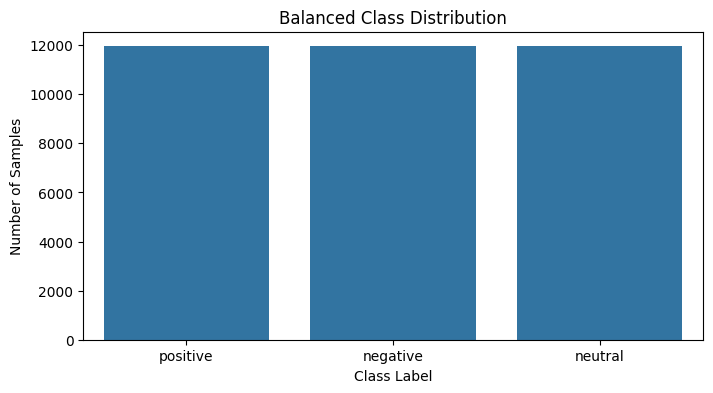

In [19]:
# Balance the dataset by upsampling minority classes
from sklearn.utils import resample

# Combine texts and labels into a DataFrame
balance_df = pd.DataFrame({'text': texts, 'label': labels})

# Find the maximum class size
max_size = balance_df['label'].value_counts().max()

# Upsample each class to max_size
balanced_list = []
for label in balance_df['label'].unique():
    class_subset = balance_df[balance_df['label'] == label]
    upsampled = resample(class_subset, replace=True, n_samples=max_size, random_state=42)
    balanced_list.append(upsampled)
balanced_df = pd.concat(balanced_list)

# Visualize new class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=balanced_df['label'])
plt.title('Balanced Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.show()

# Update texts and labels for further processing
texts = balanced_df['text'].tolist()
labels = balanced_df['label'].tolist()

In [20]:
# Re-encode labels after balancing
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
y = np.array([label_to_index[label] for label in labels])
num_classes = len(label_to_index)
y_cat = to_categorical(y, num_classes=num_classes)

In [21]:
# 2. Tokenization and Embedding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

In [22]:
# 3. K-Fold Cross-Validation
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

In [23]:
# 4. Model architectures
def build_cnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_rnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        SimpleRNN(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [24]:
# 5. Training and Evaluation
results = {'CNN': [], 'RNN': [], 'LSTM': []}
for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]
    y_val_labels = y[val_idx]
    vocab_size = min(10000, len(tokenizer.word_index) + 1)

    for name, build_fn in zip(['CNN', 'RNN', 'LSTM'], [build_cnn, build_rnn, build_lstm]):
        model = build_fn(maxlen, vocab_size, num_classes)
        model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        
        acc = accuracy_score(y_val_labels, y_pred)
        prec = precision_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        mcc = matthews_corrcoef(y_val_labels, y_pred)
        mse = mean_squared_error(y_val_labels, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val_labels, y_pred)
        
        results[name].append({
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'mcc': mcc,
            'mse': mse,
            'rmse': rmse,
            'r2': r2
        })
        print(f"Fold {fold+1} {name}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 1 CNN: Acc=0.8617, Prec=0.8622, Rec=0.8617, F1=0.8617, MCC=0.7928, MSE=0.1993, RMSE=0.4464, R2=0.7004


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 1 RNN: Acc=0.8367, Prec=0.8361, Rec=0.8367, F1=0.8362, MCC=0.7552, MSE=0.2520, RMSE=0.5020, R2=0.6212


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Fold 1 LSTM: Acc=0.8299, Prec=0.8288, Rec=0.8299, F1=0.8289, MCC=0.7452, MSE=0.2618, RMSE=0.5116, R2=0.6065


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 2 CNN: Acc=0.8539, Prec=0.8531, Rec=0.8539, F1=0.8528, MCC=0.7815, MSE=0.2187, RMSE=0.4676, R2=0.6702


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 2 RNN: Acc=0.8347, Prec=0.8336, Rec=0.8347, F1=0.8338, MCC=0.7523, MSE=0.2397, RMSE=0.4896, R2=0.6385


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Fold 2 LSTM: Acc=0.8272, Prec=0.8269, Rec=0.8272, F1=0.8270, MCC=0.7409, MSE=0.2428, RMSE=0.4928, R2=0.6337


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 3 CNN: Acc=0.8515, Prec=0.8506, Rec=0.8515, F1=0.8505, MCC=0.7777, MSE=0.2193, RMSE=0.4683, R2=0.6735


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 3 RNN: Acc=0.8302, Prec=0.8332, Rec=0.8302, F1=0.8311, MCC=0.7458, MSE=0.2522, RMSE=0.5022, R2=0.6245


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Fold 3 LSTM: Acc=0.8311, Prec=0.8326, Rec=0.8311, F1=0.8303, MCC=0.7480, MSE=0.2528, RMSE=0.5028, R2=0.6237


In [25]:
# 6. Average metrics and select best model
import statistics
summary = {}
for name in results:
    avg_metrics = {metric: statistics.mean([fold[metric] for fold in results[name]]) for metric in results[name][0]}
    summary[name] = avg_metrics
    print(f"\n{name} Average Metrics:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")


CNN Average Metrics:
accuracy: 0.8557
precision: 0.8553
recall: 0.8557
f1: 0.8550
mcc: 0.7840
mse: 0.2124
rmse: 0.4608
r2: 0.6814

RNN Average Metrics:
accuracy: 0.8338
precision: 0.8343
recall: 0.8338
f1: 0.8337
mcc: 0.7511
mse: 0.2479
rmse: 0.4979
r2: 0.6281

LSTM Average Metrics:
accuracy: 0.8294
precision: 0.8294
recall: 0.8294
f1: 0.8287
mcc: 0.7447
mse: 0.2525
rmse: 0.5024
r2: 0.6213


In [26]:
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'mcc', 'mse', 'rmse', 'r2']
plot_data = []
for name in results:
    for fold_idx, fold in enumerate(results[name]):
        fold_data = {'Model': name, 'Fold': f'Fold {fold_idx + 1}'}
        fold_data.update(fold)
        plot_data.append(fold_data)
plot_df = pd.DataFrame(plot_data)

In [27]:
for metric in metrics_to_plot:
    if metric in ['mse', 'rmse']:  # For these, lower is better
        best = min(summary, key=lambda x: summary[x][metric])
    else:  # For others, higher is better
        best = max(summary, key=lambda x: summary[x][metric])
    print(f"For {metric}, the winner is {best} (score: {summary[best][metric]:.4f})")
    

print(f"\nOverall Best Model: {best}")
print(f"This is because {best} achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) \ncompared to the other two, indicating it generalizes better on this sentiment classification task.")


For accuracy, the winner is CNN (score: 0.8557)
For precision, the winner is CNN (score: 0.8553)
For recall, the winner is CNN (score: 0.8557)
For f1, the winner is CNN (score: 0.8550)
For mcc, the winner is CNN (score: 0.7840)
For mse, the winner is CNN (score: 0.2124)
For rmse, the winner is CNN (score: 0.4608)
For r2, the winner is CNN (score: 0.6814)

Overall Best Model: CNN
This is because CNN achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) 
compared to the other two, indicating it generalizes better on this sentiment classification task.


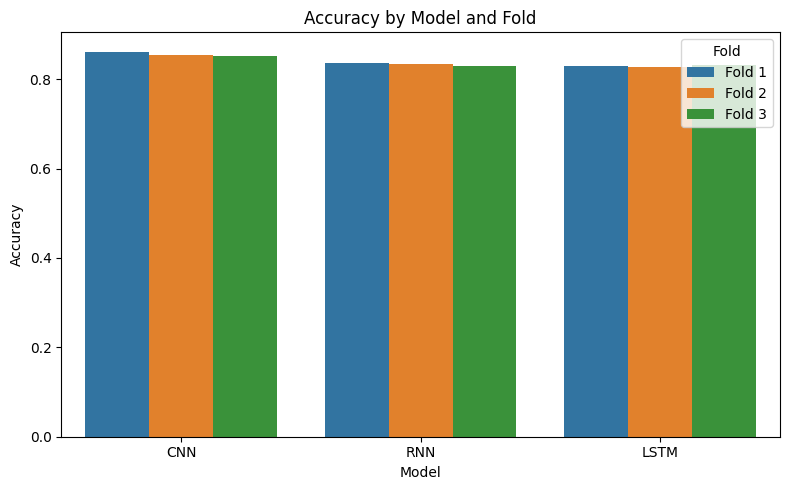

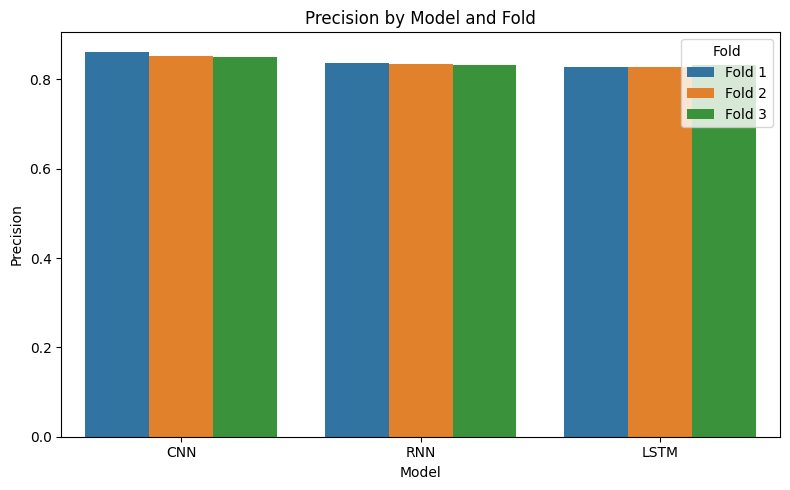

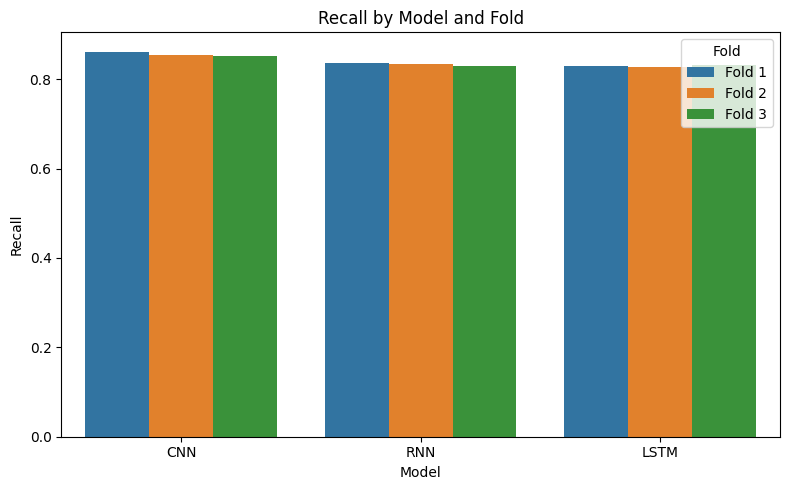

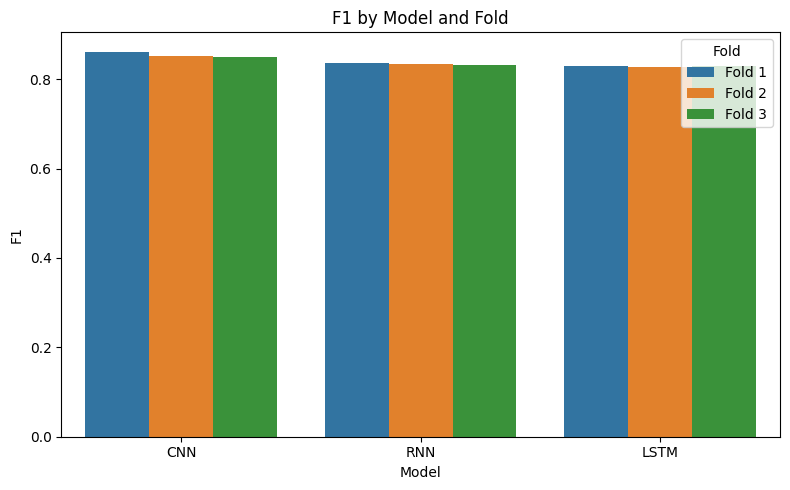

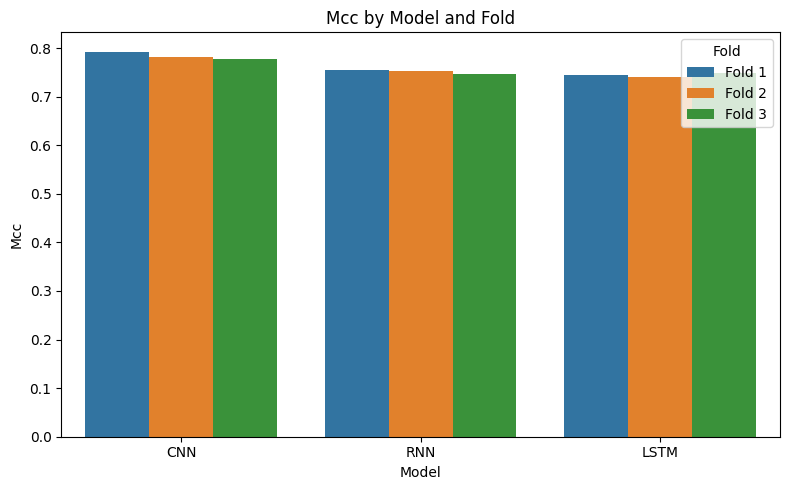

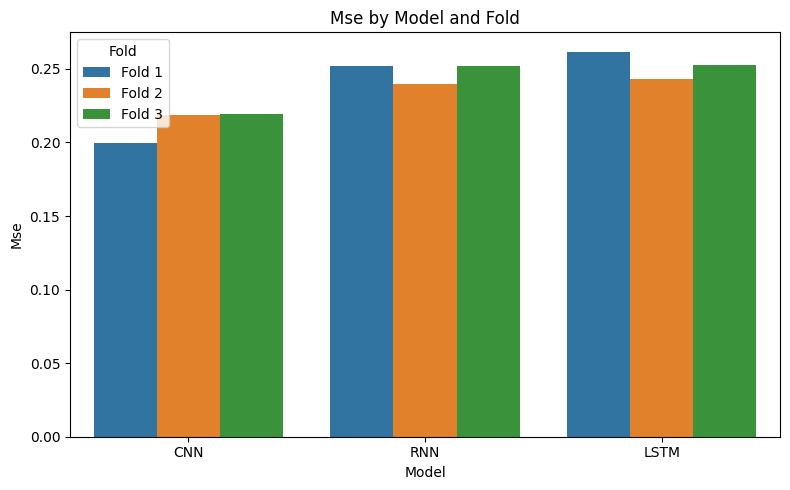

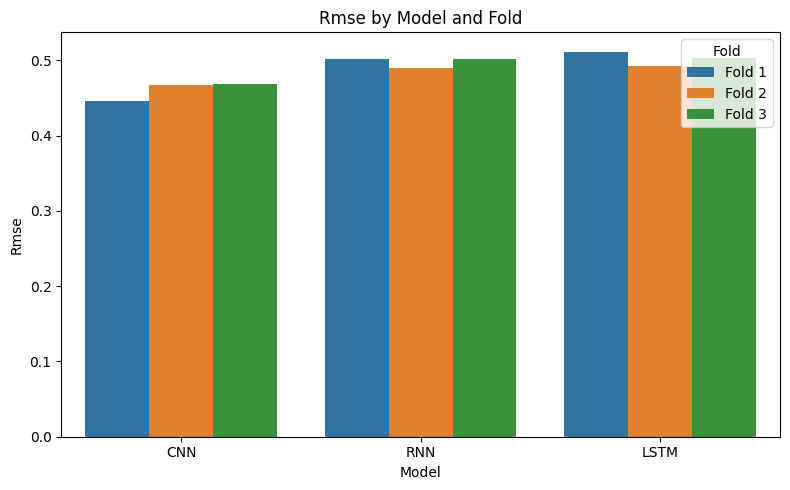

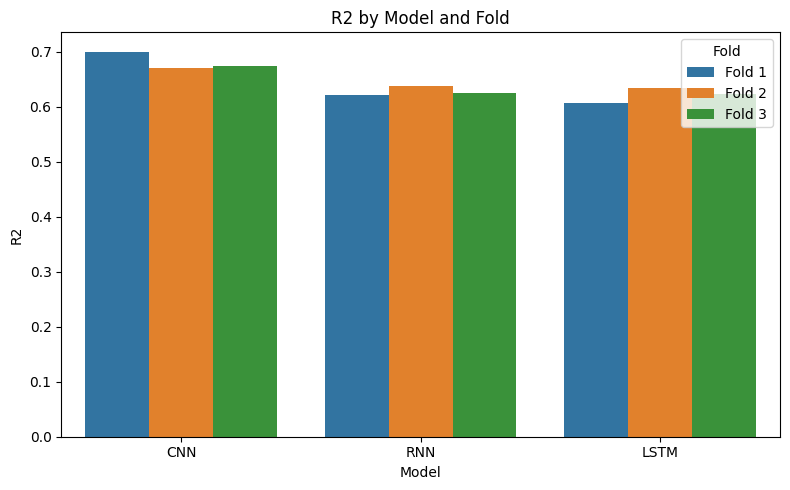

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=plot_df, x='Model', y=metric, hue='Fold')
    plt.title(f'{metric.capitalize()} by Model and Fold')
    plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()